# Am I feeding my network crap

Given that my research on the image content of optical flow images shows such huge variety is my image generation doing  anything useful to it??? Perhaps experiment with a very small network for say only 10 classes?? 

First lets look at the output for something relatively easy like cricket 

In [1]:
import os
import sys


up1 = os.path.abspath('../../utils/') 
up2 = os.path.abspath('../../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGeneratorVideoAccuracy
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Is it the data or my classifier

I am starting to wonder what it is about my optical flow data that might be causing so much easier. Regardless about the unconverged flow images I feel the author of the data still managed with it. So there's essentially two things I can either get a large amount of improvement simply on how I train my classifier (slower?), or my data set is not quite right. I've already seen that I wasn't even doing any random transforms on my opt flow images courtesy my badly written opt flow data generator. 
Any how what I am aiming to do is use a stinkingly cheap data model to explore what might be wrong. 

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.initializers import Ones
from keras import optimizers

def getModel(lr=1e-2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))

    optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [4]:
model_big_batch = getModel(lr=1e-4)

In [5]:
model_big_batch.load_weights('../../data/weights/model_slow_lr_big_batch.hdf5')

In [28]:
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow


params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
                'sample_size' : 20,
                'n_classes' : 10,
           'validation' : True}

id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')


validation_generator = DataGeneratorVideoAccuracy(id_test[0], id_test[1], **params_valid)

In [7]:
X = None
y = None

for i, (_X,_y) in enumerate(validation_generator):
    X = _X
    y = _y
    if i == 1:
        break

ID:  v_ApplyEyeMakeup_g01_c01
ID:  v_ApplyEyeMakeup_g01_c02


In [8]:
X.shape

(20, 224, 224, 2)

In [9]:
_y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
pred = model_big_batch.predict(X)

In [11]:
pred_mean = pred.mean(axis=0)

In [12]:
pred_mean.argmax()

0

In [13]:
y.shape

(20, 10)

In [19]:
count = 0
for i, (_X,_y) in enumerate(validation_generator):
    pred = model_big_batch.predict(_X)
    count = count + (1 if pred.mean(axis=0).argmax() == _y[0].argmax() else 0)
    if i == len(validation_generator):
        break
    print("i", i)
    print('result: ', 1 if pred.mean(axis=0).argmax() == _y[0].argmax() else 0)

ID:  v_ApplyEyeMakeup_g01_c01
i 0
result:  0
ID:  v_ApplyEyeMakeup_g01_c02
i 1
result:  1
ID:  v_ApplyEyeMakeup_g01_c03
i 2
result:  1
ID:  v_ApplyEyeMakeup_g01_c04
i 3
result:  1
ID:  v_ApplyEyeMakeup_g01_c05
i 4
result:  1
ID:  v_ApplyEyeMakeup_g01_c06
i 5
result:  1
ID:  v_ApplyEyeMakeup_g02_c01
i 6
result:  0
ID:  v_ApplyEyeMakeup_g02_c02
i 7
result:  1
ID:  v_ApplyEyeMakeup_g02_c03
i 8
result:  1
ID:  v_ApplyEyeMakeup_g02_c04
i 9
result:  0
ID:  v_ApplyEyeMakeup_g03_c01
i 10
result:  1
ID:  v_ApplyEyeMakeup_g03_c02
i 11
result:  0
ID:  v_ApplyEyeMakeup_g03_c03
i 12
result:  1
ID:  v_ApplyEyeMakeup_g03_c04
i 13
result:  1
ID:  v_ApplyEyeMakeup_g03_c05
i 14
result:  1
ID:  v_ApplyEyeMakeup_g03_c06
i 15
result:  0
ID:  v_ApplyEyeMakeup_g04_c01
i 16
result:  1
ID:  v_ApplyEyeMakeup_g04_c02
i 17
result:  1
ID:  v_ApplyEyeMakeup_g04_c03
i 18
result:  0
ID:  v_ApplyEyeMakeup_g04_c04
i 19
result:  1
ID:  v_ApplyEyeMakeup_g04_c05
i 20
result:  1
ID:  v_ApplyEyeMakeup_g04_c06
i 21
result:  

i 187
result:  1
ID:  v_BandMarching_g01_c06
i 188
result:  1
ID:  v_BandMarching_g01_c07
i 189
result:  1
ID:  v_BandMarching_g02_c01
i 190
result:  0
ID:  v_BandMarching_g02_c02
i 191
result:  0
ID:  v_BandMarching_g02_c03
i 192
result:  1
ID:  v_BandMarching_g02_c04
i 193
result:  1
ID:  v_BandMarching_g02_c05
i 194
result:  1
ID:  v_BandMarching_g02_c06
i 195
result:  1
ID:  v_BandMarching_g02_c07
i 196
result:  0
ID:  v_BandMarching_g03_c01
i 197
result:  1
ID:  v_BandMarching_g03_c02
i 198
result:  1
ID:  v_BandMarching_g03_c03
i 199
result:  1
ID:  v_BandMarching_g03_c04
i 200
result:  0
ID:  v_BandMarching_g03_c05
i 201
result:  0
ID:  v_BandMarching_g03_c06
i 202
result:  1
ID:  v_BandMarching_g03_c07
i 203
result:  1
ID:  v_BandMarching_g04_c01
i 204
result:  0
ID:  v_BandMarching_g04_c02
i 205
result:  1
ID:  v_BandMarching_g04_c03
i 206
result:  1
ID:  v_BandMarching_g04_c04
i 207
result:  1
ID:  v_BandMarching_g05_c01
i 208
result:  1
ID:  v_BandMarching_g05_c02
i 209
resu

i 370
result:  0
ID:  v_BenchPress_g05_c04
i 371
result:  0
ID:  v_BenchPress_g05_c05
i 372
result:  0
ID:  v_BenchPress_g05_c06
i 373
result:  0
ID:  v_BenchPress_g05_c07
i 374
result:  0
ID:  v_BenchPress_g06_c01
i 375
result:  0
ID:  v_BenchPress_g06_c02
i 376
result:  0
ID:  v_BenchPress_g06_c03
i 377
result:  0
ID:  v_BenchPress_g06_c04
i 378
result:  1
ID:  v_BenchPress_g06_c05
i 379
result:  0
ID:  v_BenchPress_g06_c06
i 380
result:  0
ID:  v_BenchPress_g06_c07
i 381
result:  0
ID:  v_BenchPress_g07_c01
i 382
result:  0
ID:  v_BenchPress_g07_c02
i 383
result:  1
ID:  v_BenchPress_g07_c03
i 384
result:  1
ID:  v_BenchPress_g07_c04
i 385
result:  0
ID:  v_BenchPress_g07_c05
i 386
result:  1
ID:  v_BenchPress_g07_c06
i 387
result:  1
ID:  v_BenchPress_g07_c07
i 388
result:  1
ID:  v_ApplyEyeMakeup_g01_c01


In [15]:

count

NameError: name 'count' is not defined

In [16]:
216/len(validation_generator)


0.5552699228791774

In [17]:
pred = model_big_batch.evaluate_generator(generator=validation_generator)

ID:  v_ApplyEyeMakeup_g01_c01
ID:  v_ApplyEyeMakeup_g01_c02
ID:  v_ApplyEyeMakeup_g01_c03
ID:  v_ApplyEyeMakeup_g01_c04
ID:  v_ApplyEyeMakeup_g01_c05
ID:  v_ApplyEyeMakeup_g01_c06
ID:  v_ApplyEyeMakeup_g02_c01
ID:  v_ApplyEyeMakeup_g02_c02
ID:  v_ApplyEyeMakeup_g02_c03
ID:  v_ApplyEyeMakeup_g02_c04
ID:  v_ApplyEyeMakeup_g03_c01
ID:  v_ApplyEyeMakeup_g03_c02
ID:  v_ApplyEyeMakeup_g03_c03
ID:  v_ApplyEyeMakeup_g03_c04
ID:  v_ApplyEyeMakeup_g03_c05
ID:  v_ApplyEyeMakeup_g03_c06
ID:  v_ApplyEyeMakeup_g04_c01
ID:  v_ApplyEyeMakeup_g04_c02
ID:  v_ApplyEyeMakeup_g04_c03
ID:  v_ApplyEyeMakeup_g04_c04
ID:  v_ApplyEyeMakeup_g04_c05
ID:  v_ApplyEyeMakeup_g04_c06
ID:  v_ApplyEyeMakeup_g04_c07
ID:  v_ApplyEyeMakeup_g05_c01
ID:  v_ApplyEyeMakeup_g05_c02
ID:  v_ApplyEyeMakeup_g05_c03
ID:  v_ApplyEyeMakeup_g05_c04
ID:  v_ApplyEyeMakeup_g05_c05
ID:  v_ApplyEyeMakeup_g05_c06
ID:  v_ApplyEyeMakeup_g05_c07
ID:  v_ApplyEyeMakeup_g06_c01
ID:  v_ApplyEyeMakeup_g06_c02
ID:  v_ApplyEyeMakeup_g06_c03
ID:  v_App

ID:  v_Basketball_g06_c03
ID:  v_Basketball_g06_c04
ID:  v_Basketball_g07_c01
ID:  v_Basketball_g07_c02
ID:  v_Basketball_g07_c03
ID:  v_Basketball_g07_c04
ID:  v_BasketballDunk_g01_c01
ID:  v_BasketballDunk_g01_c02
ID:  v_BasketballDunk_g01_c03
ID:  v_BasketballDunk_g01_c04
ID:  v_BasketballDunk_g01_c05
ID:  v_BasketballDunk_g01_c06
ID:  v_BasketballDunk_g01_c07
ID:  v_BasketballDunk_g02_c01
ID:  v_BasketballDunk_g02_c02
ID:  v_BasketballDunk_g02_c03
ID:  v_BasketballDunk_g02_c04
ID:  v_BasketballDunk_g03_c01
ID:  v_BasketballDunk_g03_c02
ID:  v_BasketballDunk_g03_c03
ID:  v_BasketballDunk_g03_c04
ID:  v_BasketballDunk_g03_c05
ID:  v_BasketballDunk_g03_c06
ID:  v_BasketballDunk_g04_c01
ID:  v_BasketballDunk_g04_c02
ID:  v_BasketballDunk_g04_c03
ID:  v_BasketballDunk_g04_c04
ID:  v_BasketballDunk_g05_c01
ID:  v_BasketballDunk_g05_c02
ID:  v_BasketballDunk_g05_c03
ID:  v_BasketballDunk_g05_c04
ID:  v_BasketballDunk_g05_c05
ID:  v_BasketballDunk_g05_c06
ID:  v_BasketballDunk_g06_c01
ID: 

In [18]:
pred

[2.103222005320641, 0.481619537527886]

## Unexpected!
That was a bit unexpected, so I have a lower validation score on a per frame basis it seems when using evaluate_generator. Let me try my the normal validation generator which feeds  randomly from the smaller data set

In [34]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow



validation_options = { 'rescale' : 1./255 }


params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : True}

id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [35]:
pred = model_big_batch.evaluate_generator(generator=validation_generator)

In [36]:
pred

[1.4591765652100246, 0.5182291666666666]

In [22]:
len(validation_generator)

6

In [25]:
pred = model_big_batch.evaluate_generator(generator=validation_generator, steps=150)

In [26]:
pred

[1.470314884185791, 0.53625]

In [37]:
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow


params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
                'sample_size' : 1,
                'n_classes' : 10,
           'validation' : True}

id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')


validation_generator = DataGeneratorVideoAccuracy(id_test[0], id_test[1], **params_valid)

In [30]:
pred = model_big_batch.evaluate_generator(generator=validation_generator)

ID:  v_ApplyEyeMakeup_g01_c01
ID:  v_ApplyEyeMakeup_g01_c02
ID:  v_ApplyEyeMakeup_g01_c03
ID:  v_ApplyEyeMakeup_g01_c04
ID:  v_ApplyEyeMakeup_g01_c05
ID:  v_ApplyEyeMakeup_g01_c06
ID:  v_ApplyEyeMakeup_g02_c01
ID:  v_ApplyEyeMakeup_g02_c02
ID:  v_ApplyEyeMakeup_g02_c03
ID:  v_ApplyEyeMakeup_g02_c04
ID:  v_ApplyEyeMakeup_g03_c01
ID:  v_ApplyEyeMakeup_g03_c02
ID:  v_ApplyEyeMakeup_g03_c03
ID:  v_ApplyEyeMakeup_g03_c04
ID:  v_ApplyEyeMakeup_g03_c05
ID:  v_ApplyEyeMakeup_g03_c06
ID:  v_ApplyEyeMakeup_g04_c01
ID:  v_ApplyEyeMakeup_g04_c02
ID:  v_ApplyEyeMakeup_g04_c03
ID:  v_ApplyEyeMakeup_g04_c04
ID:  v_ApplyEyeMakeup_g04_c05
ID:  v_ApplyEyeMakeup_g04_c06
ID:  v_ApplyEyeMakeup_g04_c07
ID:  v_ApplyEyeMakeup_g05_c01
ID:  v_ApplyEyeMakeup_g05_c02
ID:  v_ApplyEyeMakeup_g05_c03
ID:  v_ApplyEyeMakeup_g05_c04
ID:  v_ApplyEyeMakeup_g05_c05
ID:  v_ApplyEyeMakeup_g05_c06
ID:  v_ApplyEyeMakeup_g05_c07
ID:  v_ApplyEyeMakeup_g06_c01
ID:  v_ApplyEyeMakeup_g06_c02
ID:  v_ApplyEyeMakeup_g06_c03
ID:  v_App

ID:  v_Basketball_g06_c04
ID:  v_Basketball_g07_c01
ID:  v_Basketball_g07_c02
ID:  v_Basketball_g07_c03
ID:  v_Basketball_g07_c04
ID:  v_BasketballDunk_g01_c01
ID:  v_BasketballDunk_g01_c02
ID:  v_BasketballDunk_g01_c03
ID:  v_BasketballDunk_g01_c04
ID:  v_BasketballDunk_g01_c05
ID:  v_BasketballDunk_g01_c06
ID:  v_BasketballDunk_g01_c07
ID:  v_BasketballDunk_g02_c01
ID:  v_BasketballDunk_g02_c02
ID:  v_BasketballDunk_g02_c03
ID:  v_BasketballDunk_g02_c04
ID:  v_BasketballDunk_g03_c01
ID:  v_BasketballDunk_g03_c02
ID:  v_BasketballDunk_g03_c03
ID:  v_BasketballDunk_g03_c04
ID:  v_BasketballDunk_g03_c05
ID:  v_BasketballDunk_g03_c06
ID:  v_BasketballDunk_g04_c01
ID:  v_BasketballDunk_g04_c02
ID:  v_BasketballDunk_g04_c03
ID:  v_BasketballDunk_g04_c04
ID:  v_BasketballDunk_g05_c01
ID:  v_BasketballDunk_g05_c02
ID:  v_BasketballDunk_g05_c03
ID:  v_BasketballDunk_g05_c04
ID:  v_BasketballDunk_g05_c05
ID:  v_BasketballDunk_g05_c06
ID:  v_BasketballDunk_g06_c01
ID:  v_BasketballDunk_g06_c02


In [31]:
pred

[3.127245443578671, 0.42159383033419023]

In [32]:
pred = model_big_batch.evaluate_generator(generator=validation_generator)

ID:  v_ApplyEyeMakeup_g01_c01
ID:  v_ApplyEyeMakeup_g01_c02
ID:  v_ApplyEyeMakeup_g01_c03
ID:  v_ApplyEyeMakeup_g01_c04
ID:  v_ApplyEyeMakeup_g01_c05
ID:  v_ApplyEyeMakeup_g01_c06
ID:  v_ApplyEyeMakeup_g02_c01
ID:  v_ApplyEyeMakeup_g02_c02
ID:  v_ApplyEyeMakeup_g02_c03
ID:  v_ApplyEyeMakeup_g02_c04
ID:  v_ApplyEyeMakeup_g03_c01
ID:  v_ApplyEyeMakeup_g03_c02
ID:  v_ApplyEyeMakeup_g03_c03
ID:  v_ApplyEyeMakeup_g03_c04
ID:  v_ApplyEyeMakeup_g03_c05
ID:  v_ApplyEyeMakeup_g03_c06
ID:  v_ApplyEyeMakeup_g04_c01
ID:  v_ApplyEyeMakeup_g04_c02
ID:  v_ApplyEyeMakeup_g04_c03
ID:  v_ApplyEyeMakeup_g04_c04
ID:  v_ApplyEyeMakeup_g04_c05
ID:  v_ApplyEyeMakeup_g04_c06
ID:  v_ApplyEyeMakeup_g04_c07
ID:  v_ApplyEyeMakeup_g05_c01
ID:  v_ApplyEyeMakeup_g05_c02
ID:  v_ApplyEyeMakeup_g05_c03
ID:  v_ApplyEyeMakeup_g05_c04
ID:  v_ApplyEyeMakeup_g05_c05
ID:  v_ApplyEyeMakeup_g05_c06
ID:  v_ApplyEyeMakeup_g05_c07
ID:  v_ApplyEyeMakeup_g06_c01
ID:  v_ApplyEyeMakeup_g06_c02
ID:  v_ApplyEyeMakeup_g06_c03
ID:  v_App

ID:  v_Basketball_g06_c04
ID:  v_Basketball_g07_c01
ID:  v_Basketball_g07_c02
ID:  v_Basketball_g07_c03
ID:  v_Basketball_g07_c04
ID:  v_BasketballDunk_g01_c01
ID:  v_BasketballDunk_g01_c02
ID:  v_BasketballDunk_g01_c03
ID:  v_BasketballDunk_g01_c04
ID:  v_BasketballDunk_g01_c05
ID:  v_BasketballDunk_g01_c06
ID:  v_BasketballDunk_g01_c07
ID:  v_BasketballDunk_g02_c01
ID:  v_BasketballDunk_g02_c02
ID:  v_BasketballDunk_g02_c03
ID:  v_BasketballDunk_g02_c04
ID:  v_BasketballDunk_g03_c01
ID:  v_BasketballDunk_g03_c02
ID:  v_BasketballDunk_g03_c03
ID:  v_BasketballDunk_g03_c04
ID:  v_BasketballDunk_g03_c05
ID:  v_BasketballDunk_g03_c06
ID:  v_BasketballDunk_g04_c01
ID:  v_BasketballDunk_g04_c02
ID:  v_BasketballDunk_g04_c03
ID:  v_BasketballDunk_g04_c04
ID:  v_BasketballDunk_g05_c01
ID:  v_BasketballDunk_g05_c02
ID:  v_BasketballDunk_g05_c03
ID:  v_BasketballDunk_g05_c04
ID:  v_BasketballDunk_g05_c05
ID:  v_BasketballDunk_g05_c06
ID:  v_BasketballDunk_g06_c01
ID:  v_BasketballDunk_g06_c02


In [33]:
pred

[3.6866196105386426, 0.39588688946015427]

# What have I learned?

Computing accuracies yield different statistic  on how you account you total up your true positive. Average pooling tells you the overall true average over classes. Or you could average over the max pooling per frame over lots of frames. These give you the same score. Selecting one frame per video randomly pretty much always give you a bad score. As you are not getting the best per video as with the other methods. 

One thing I'm wondering is if softmax scores are distributed randomly 

In [46]:
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow


params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
                'sample_size' : 20,
                'n_classes' : 10,
           'validation' : True}

id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')


validation_generator = DataGeneratorVideoAccuracy(id_test[0], id_test[1], **params_valid)

In [127]:
X = None
y = None

for i, (_X,_y) in enumerate(validation_generator):
    X = _X
    y = _y
    if i == 1:
        break

ID:  v_ApplyEyeMakeup_g01_c01
ID:  v_ApplyEyeMakeup_g01_c02


In [128]:
pred = model_big_batch.predict(X)

In [129]:
pred.shape

(20, 10)

In [130]:
for i in range(0, pred.shape[0]):
    pred[i,:] = pred[i,:] / pred[i,:].sum()

In [131]:
pred.argmax(axis=1)

array([7, 0, 2, 7, 7, 2, 2, 2, 7, 0, 0, 0, 2, 0, 7, 0, 2, 2, 0, 7])

In [132]:
pred[1,:]

array([9.9443352e-01, 1.8251859e-06, 2.3870544e-04, 2.3947849e-03,
       2.7758146e-05, 5.5549183e-04, 2.3426986e-03, 5.1899397e-06,
       3.7442449e-10, 2.5134184e-09], dtype=float32)

(array([0.25      , 0.25      , 0.        , 0.        , 0.21428571]),
 array([0. , 1.4, 2.8, 4.2, 5.6, 7. ]),
 <a list of 5 Patch objects>)

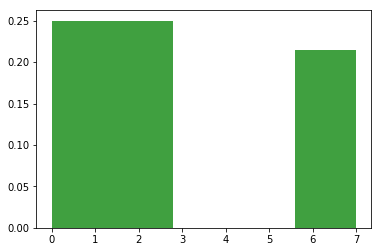

In [133]:
plt.hist(pred.argmax(axis=1), 5, density=True, facecolor='g', alpha=0.75)

# Result

So what I've noticed then is that firstly can't use softmax probabilities even when L1 normalized to 1. One still has to max pool it (argmax) and rather look at distribution of predictions. You can definitely see that using each individual frame results in quite low predictabiliy. So a dependence on what video and what frame one is using. 

It makes me think, one could in a sense use these videos to determine what are the most relevant  frames for picking out what is going for that class. Essentially I wonder if that's what is already done for prediction action tubes. If you filtered your training data that way then surely you'd get more relevant data sets and less noise then hopefully more chance 